<a href="https://colab.research.google.com/github/LeoJAndrade/Machine-Learning-2-Fatec/blob/main/Etherum_Predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [208]:
!pip install pymc

In [209]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import yfinance as yf
import pytensor.tensor as tt
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [210]:
tickerData = yf.Ticker("ETH-USD")

df = tickerData.history(period='1y', interval='1d')

In [211]:
df['Percentage Variation'] = ((df['Close'] - df['Open']) / df['Open']) * 100

## Exploratory Data Analysis

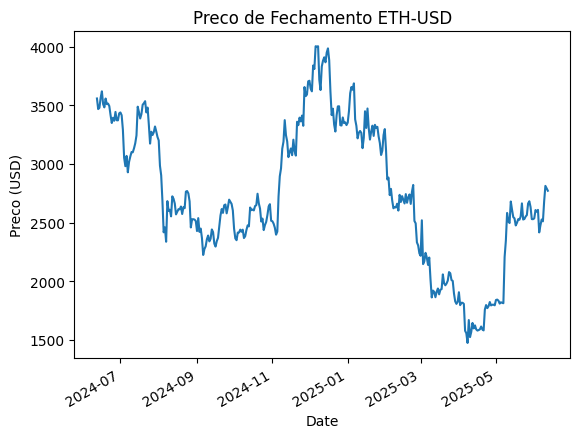

In [212]:
df['Close'].plot(title='Preco de Fechamento ETH-USD')
plt.ylabel('Preco (USD)')
plt.show()

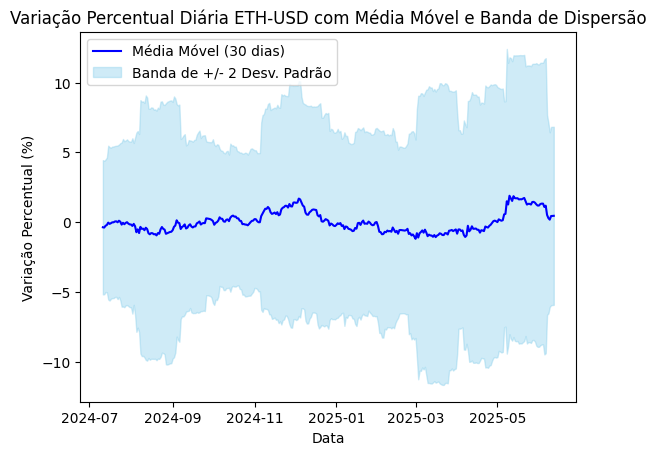

In [213]:
window_size = 30

df['Rolling Mean Var'] = df['Percentage Variation'].rolling(window=window_size).mean()
df['Rolling Std Var'] = df['Percentage Variation'].rolling(window=window_size).std()

num_std_devs= 2
df['Upper Band'] = df['Rolling Mean Var'] + (df['Rolling Std Var'] * num_std_devs)
df['Lower Band'] = df['Rolling Mean Var'] - (df['Rolling Std Var'] * num_std_devs)

# Plotar a média móvel
plt.plot(df.index, df['Rolling Mean Var'], label=f'Média Móvel ({window_size} dias)', color='blue')

# Preencher a banda de volatilidade/dispersão
plt.fill_between(df.index, df['Lower Band'], df['Upper Band'],
                 color='skyblue', alpha=0.4, label=f'Banda de +/- {num_std_devs} Desv. Padrão')

plt.title('Variação Percentual Diária ETH-USD com Média Móvel e Banda de Dispersão')
plt.ylabel('Variação Percentual (%)') # Certifique-se que a unidade está correta
plt.xlabel('Data')
plt.legend()
plt.show()

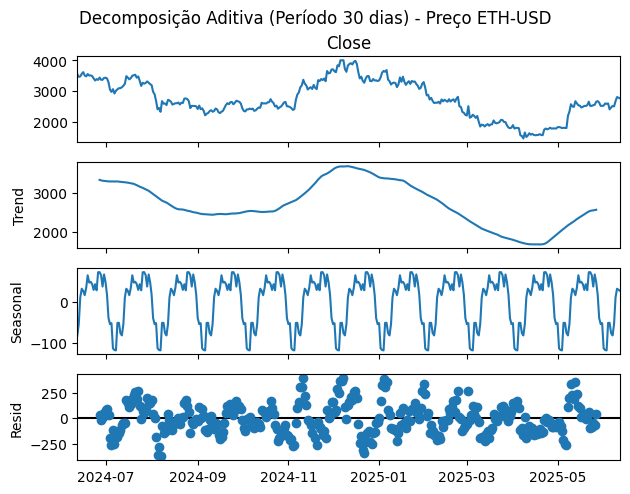

In [214]:
if df.index.tz is not None:
    df.index = df.index.tz_localize(None)

decomposition_additive_30 = seasonal_decompose(df['Close'], model='additive', period=30)
fig_additive_30 = decomposition_additive_30.plot()
fig_additive_30.suptitle('Decomposição Aditiva (Período 30 dias) - Preço ETH-USD', y=1.02)
plt.show()

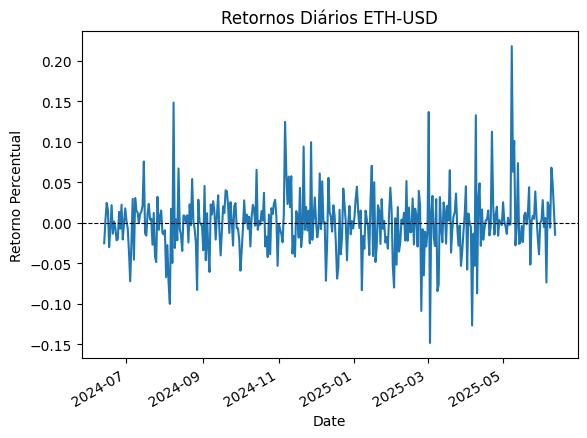


Teste ADF para os Retornos Diários ETH-USD:
Estatística ADF: -12.761174897661565
Valor-p: 8.137346736343465e-24
Valores Críticos:
	1%: -3.448544133483233
	5%: -2.8695574079525565
	10%: -2.5710411593052713
Conclusão: Rejeitamos a hipótese nula (H0). A série de retornos é provavelmente estacionária.


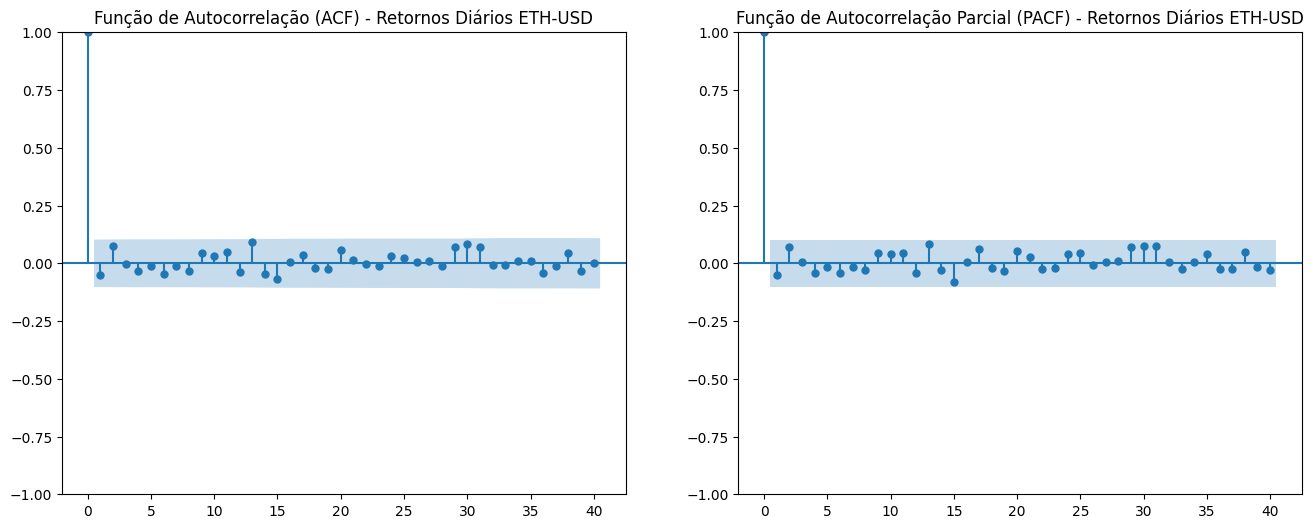

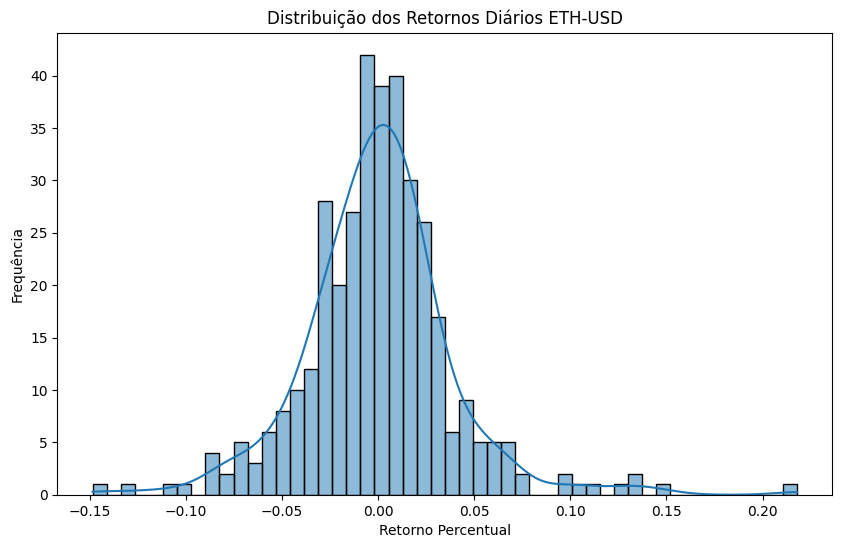


Estatísticas descritivas dos retornos diários:
count    364.000000
mean       0.000047
std        0.038596
min       -0.148479
25%       -0.021069
50%        0.000165
75%        0.017806
max        0.217988
Name: Close, dtype: float64


In [215]:
# Calculando os retornos diários percentuais (já feito, mas para clareza)
daily_returns_nan = df['Close'].pct_change()
daily_returns = daily_returns_nan.dropna()

# Plotando os retornos diários (já feito, mas útil aqui)
daily_returns.plot(title='Retornos Diários ETH-USD')
plt.ylabel('Retorno Percentual')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.show()

# Teste ADF para os retornos diários
result_adf_returns = adfuller(daily_returns)
print(f'\nTeste ADF para os Retornos Diários ETH-USD:')
print(f'Estatística ADF: {result_adf_returns[0]}')
print(f'Valor-p: {result_adf_returns[1]}')
print('Valores Críticos:')
for key, value in result_adf_returns[4].items():
    print(f'\t{key}: {value}')

if result_adf_returns[1] <= 0.05:
    print("Conclusão: Rejeitamos a hipótese nula (H0). A série de retornos é provavelmente estacionária.")
else:
    print("Conclusão: Não podemos rejeitar a hipótese nula (H0). A série de retornos é provavelmente não estacionária.")

# Plotando ACF e PACF para os Retornos Diários
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(daily_returns, ax=axes[0], lags=40)
axes[0].set_title('Função de Autocorrelação (ACF) - Retornos Diários ETH-USD')
plot_pacf(daily_returns, ax=axes[1], lags=40)
axes[1].set_title('Função de Autocorrelação Parcial (PACF) - Retornos Diários ETH-USD')
plt.show()

# Histograma dos retornos diários
plt.figure(figsize=(10,6))
sns.histplot(daily_returns, kde=True, bins=50)
plt.title('Distribuição dos Retornos Diários ETH-USD')
plt.xlabel('Retorno Percentual')
plt.ylabel('Frequência')
plt.show()

print("\nEstatísticas descritivas dos retornos diários:")
print(daily_returns.describe())

## Priori

In [216]:
daily_returns = df['Close']
daily_returns.index = pd.to_datetime(daily_returns.index)
daily_returns.index = (daily_returns.index - daily_returns.index[0]).days

min_day = daily_returns.index.min()
max_day = daily_returns.index.max()

print(daily_returns)
normalized_index = (daily_returns.index - min_day) / (max_day - min_day)

daily_returns.index = normalized_index

daily_returns

Date
0      3559.617676
1      3469.281250
2      3480.271973
3      3565.549561
4      3620.563477
          ...     
360    2526.505371
361    2510.787109
362    2681.517090
363    2813.517578
365    2771.835938
Name: Close, Length: 365, dtype: float64


,Close
Date,
0.000000,3559.617676
0.002740,3469.281250
0.005479,3480.271973
0.008219,3565.549561
0.010959,3620.563477
...,...
0.986301,2526.505371
0.989041,2510.787109
0.991781,2681.517090


[Text(0.5, 1.0, 'y train-test split '), Text(0.5, 0, 't'), Text(0, 0.5, '')]

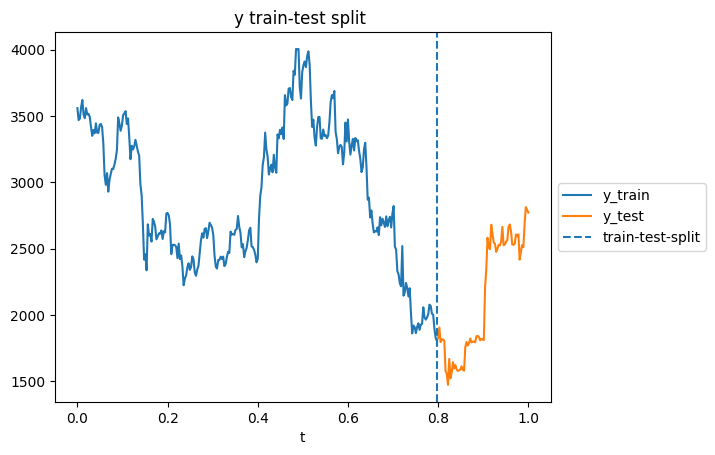

In [217]:
x = daily_returns.index.values.T
y = daily_returns.values.T
n = len(daily_returns)

prop_train = 0.8
n_train = round(prop_train * n)

x_train = x[:n_train]
y_train = y[:n_train]

x_test = x[n_train:]
y_test = y[n_train:]

# Plot.
fig, ax = plt.subplots()
sns.lineplot(x=x_train.flatten(), y=y_train.flatten(), label='y_train', ax=ax)
sns.lineplot(x=x_test.flatten(), y=y_test.flatten(), label='y_test', ax=ax)
ax.axvline(x=x_train.flatten()[-1], linestyle='--', label='train-test-split')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='y train-test split ', xlabel='t', ylabel='')


In [218]:
with pm.Model() as model:

    l_ratquad = pm.HalfNormal('l_ratquad', sigma=1)
    alpha_ratquad = pm.HalfNormal('alpha_ratquad', sigma=1)
    sigma_ratquad = pm.HalfNormal('sigma_ratquad', sigma=1)

    l_matern32 = pm.HalfNormal('l_matern32', sigma=1)
    sigma_matern32 = pm.HalfNormal('sigma_matern32', sigma=1)

    cov_ratquad = sigma_ratquad * pm.gp.cov.RatQuad(1, l_ratquad, alpha_ratquad)
    cov_matern32 = sigma_matern32 * pm.gp.cov.Matern32(1, l_matern32)

    cov = cov_ratquad + cov_matern32

    a = pm.Normal("a",0,1)
    b = pm.Normal("b",0.5,0.05)
    trend = pm.Deterministic("trend",a + b*x_train)
    M = pm.gp.mean.Linear([b],a)

    gp = pm.gp.Marginal(mean_func=M, cov_func=cov)
    sigma = pm.HalfNormal('sigma', sigma=1)
    y_obs = gp.marginal_likelihood('y', X=x_train.reshape(-1,1),y=y_train, noise=sigma)

/usr/local/lib/python3.11/dist-packages/pymc/gp/gp.py:55: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)


In [219]:
with model:
    prior = pm.sample_prior_predictive()

In [220]:
prior

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

<ipython-input-221-1954004962>:4: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(prior, group="prior_predictive", num_samples=100)["y"]
<ipython-input-221-1954004962>:13: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(prior, group="prior", num_samples=100)["trend"] * y_train.max(),


Text(0.5, 1.0, 'Prior trend lines')

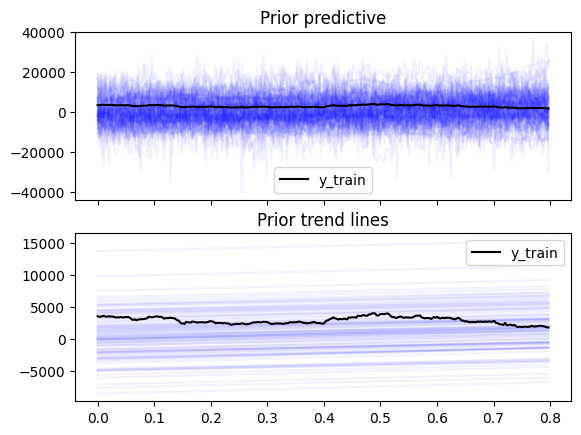

In [221]:

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
ax[0].plot(
    x_train,
    az.extract_dataset(prior, group="prior_predictive", num_samples=100)["y"]
    * y_train.max(),
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_train.flatten(), y=y_train.flatten(), color="k", label='y_train', ax=ax[0])
ax[0].set_title("Prior predictive")
ax[1].plot(
    x_train,
    az.extract_dataset(prior, group="prior", num_samples=100)["trend"] * y_train.max(),
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_train.flatten(), y=y_train.flatten(), color="k",label='y_train', ax=ax[1])
ax[1].set_title("Prior trend lines")

In [222]:
with pm.Model() as model:

    l_ratquad = pm.HalfNormal('l_ratquad', sigma=1)
    alpha_ratquad = pm.HalfNormal('alpha_ratquad', sigma=2)
    sigma_ratquad = pm.HalfNormal('sigma_ratquad', sigma=1)

    l_matern32 = pm.HalfNormal('l_matern32', sigma=0.1)
    sigma_matern32 = pm.HalfNormal('sigma_matern32', sigma=0.1)

    cov_ratquad = sigma_ratquad * pm.gp.cov.RatQuad(1, l_ratquad, alpha_ratquad)
    cov_matern32 = sigma_matern32 * pm.gp.cov.Matern32(1, l_matern32)

    cov = cov_ratquad + cov_matern32

    a = pm.Normal("a",0,1)
    b = pm.Normal("b",0,0.125)
    trend = pm.Deterministic("trend",a + b*x_train)
    M = pm.gp.mean.Linear([b],a)

    gp = pm.gp.Marginal(mean_func=M, cov_func=cov)
    sigma = pm.HalfNormal('sigma', sigma=1)
    y_obs = gp.marginal_likelihood('y', X=x_train.reshape(-1,1),y=y_train, noise=sigma)


/usr/local/lib/python3.11/dist-packages/pymc/gp/gp.py:55: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)


In [223]:
with model:
  prior = pm.sample_prior_predictive()

<ipython-input-224-2275263404>:4: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(prior, group="prior_predictive", num_samples=100)["y"]
<ipython-input-224-2275263404>:13: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(prior, group="prior", num_samples=100)["trend"] * y_train.max(),


Text(0.5, 1.0, 'Prior trend lines')

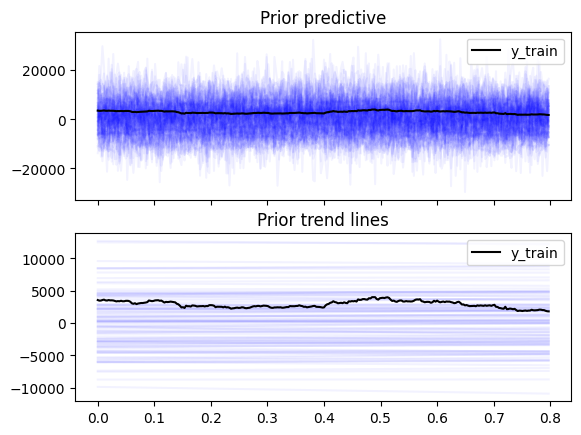

In [224]:

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
ax[0].plot(
    x_train,
    az.extract_dataset(prior, group="prior_predictive", num_samples=100)["y"]
    * y_train.max(),
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_train.flatten(), y=y_train.flatten(), color="k", label='y_train', ax=ax[0])
ax[0].set_title("Prior predictive")
ax[1].plot(
    x_train,
    az.extract_dataset(prior, group="prior", num_samples=100)["trend"] * y_train.max(),
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_train.flatten(), y=y_train.flatten(), color="k",label='y_train', ax=ax[1])
ax[1].set_title("Prior trend lines")


In [225]:
with model:
  trace_approx = pm.fit()
  trace = trace_approx.sample()

Output()

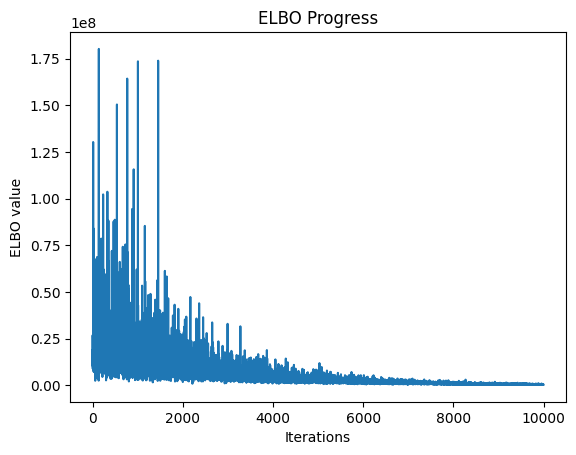

In [226]:
plt.plot(trace_approx.hist)
plt.title('ELBO Progress')
plt.xlabel('Iterations')
plt.ylabel('ELBO value')
plt.show()


In [227]:
with model:
    x_test_c = gp.conditional('x_test', x_test.reshape(-1,1))
    pred_m = pm.sample_posterior_predictive(trace, var_names=["x_test"])


Output()

<ipython-input-228-3686982793>:4: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(pred_m, group="posterior_predictive", num_samples=200)["x_test"],


Text(0.5, 1.0, 'Posterior predictive')

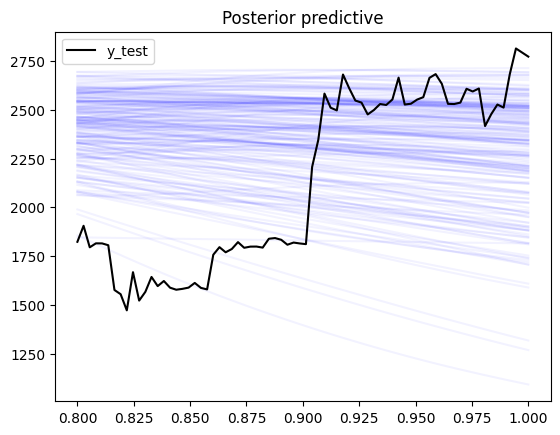

In [228]:
fig, ax = plt.subplots()
ax.plot(
    x_test,
    az.extract_dataset(pred_m, group="posterior_predictive", num_samples=200)["x_test"],
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_test.flatten(), y=y_test.flatten(), color="k", label='y_test', ax=ax)
ax.set_title("Posterior predictive")


In [229]:
with pm.Model() as model_2:
    l_matern32 = pm.Gamma('l_matern32', alpha=2, beta=0.1)
    sigma_matern32 = pm.HalfNormal('sigma_matern32', sigma=1.0)

    cov_matern32 = sigma_matern32**2 * pm.gp.cov.Matern32(input_dim=1, ls=l_matern32)

    cov = cov_matern32

    a = pm.Normal("a", mu=np.mean(y_train), sigma=np.std(y_train) * 2)
    b = pm.Normal("b", mu=0, sigma=0.5)

    mean_func = pm.gp.mean.Linear(coeffs=b, intercept=a)

    gp = pm.gp.Marginal(mean_func=mean_func, cov_func=cov)

    sigma_obs_noise = pm.HalfNormal('sigma_obs_noise', sigma=0.5)

    y_obs = gp.marginal_likelihood('y', X=x_train.reshape(-1,1), y=y_train, noise=sigma_obs_noise)

/usr/local/lib/python3.11/dist-packages/pymc/gp/gp.py:55: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)


In [230]:
with model_2:
  trace_approx_2 = pm.fit()
  trace_2 = trace_approx_2.sample()

Output()

In [231]:
with model_2:
    x_test_c = gp.conditional('x_test', x_test.reshape(-1,1))
    pred_m_2 = pm.sample_posterior_predictive(trace_2, var_names=["x_test"])

Output()

<ipython-input-232-533084169>:4: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(pred_m_2, group="posterior_predictive", num_samples=200)["x_test"],


Text(0.5, 1.0, 'Posterior predictive')

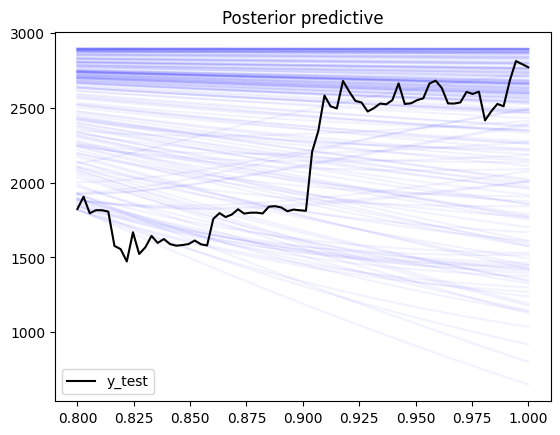

In [232]:
fig, ax = plt.subplots()
ax.plot(
    x_test,
    az.extract_dataset(pred_m_2, group="posterior_predictive", num_samples=200)["x_test"],
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_test.flatten(), y=y_test.flatten(), color="k", label='y_test', ax=ax)
ax.set_title("Posterior predictive")

In [233]:
with pm.Model() as model_3:

    l_ratquad = pm.HalfNormal('l_ratquad', sigma=1)
    alpha_ratquad = pm.HalfNormal('alpha_ratquad', sigma=1)
    sigma_ratquad = pm.HalfNormal('sigma_ratquad', sigma=1)

    l_expquad = pm.HalfNormal('l_expquad', sigma=2)
    sigma_expquad = pm.HalfNormal('sigma_expquad', sigma=2)
    cov_expquad = sigma_expquad * pm.gp.cov.ExpQuad(1, l_expquad)

    l_matern32 = pm.HalfNormal('l_matern32', sigma=0.5)
    sigma_matern32 = pm.HalfNormal('sigma_matern32', sigma=0.5)

    cov_ratquad = sigma_ratquad * pm.gp.cov.RatQuad(1, l_ratquad, alpha_ratquad)
    cov_matern32 = sigma_matern32 * pm.gp.cov.Matern32(1, l_matern32)

    cov = cov_ratquad + cov_matern32 + cov_expquad

    gp = pm.gp.Marginal(cov_func=cov)
    sigma = pm.HalfNormal('sigma', sigma=1)
    wn = pm.gp.cov.WhiteNoise(sigma)

    y_obs = gp.marginal_likelihood('y', X=x_train.reshape(-1,1),y=y_train, noise=wn)

/usr/local/lib/python3.11/dist-packages/pymc/gp/gp.py:55: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)


In [234]:
with model_3:
  prior = pm.sample_prior_predictive()

<ipython-input-235-3877524624>:4: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(prior, group="prior_predictive", num_samples=100)["y"]


Text(0.5, 1.0, 'Prior predictive')

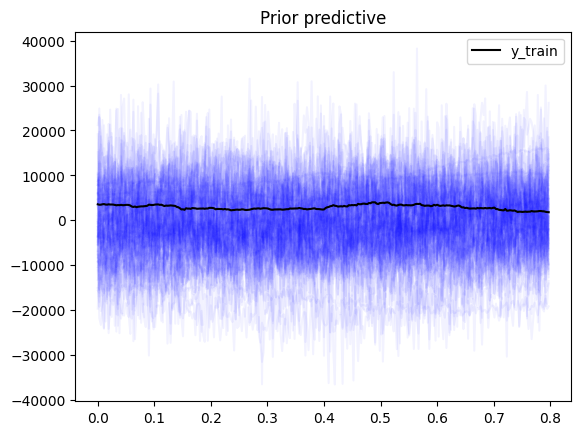

In [235]:
fig, ax = plt.subplots()
ax.plot(
    x_train,
    az.extract_dataset(prior, group="prior_predictive", num_samples=100)["y"]
    * y_train.max(),
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_train.flatten(), y=y_train.flatten(), color="k", label='y_train', ax=ax)
ax.set_title("Prior predictive")

In [236]:
with model_3:
  trace_approx_3 = pm.fit()
  trace_3 = trace_approx_3.sample()

Output()

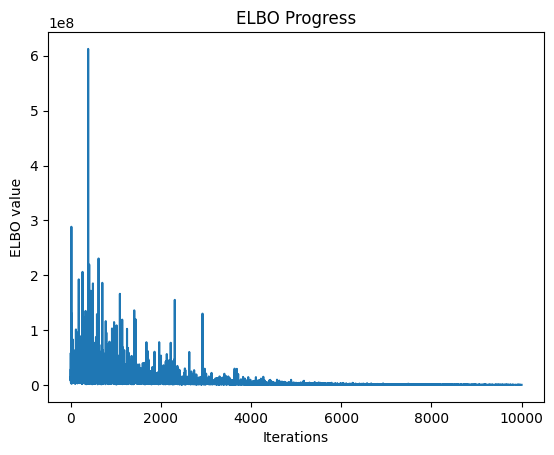

In [237]:
plt.plot(trace_approx_3.hist)
plt.title('ELBO Progress')
plt.xlabel('Iterations')
plt.ylabel('ELBO value')
plt.show()

In [238]:
with model_3:
    x_test_c = gp.conditional('x_test', x_test.reshape(-1,1))
    pred_m_2 = pm.sample_posterior_predictive(trace_3, var_names=["x_test"])

Output()

<ipython-input-239-533084169>:4: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(pred_m_2, group="posterior_predictive", num_samples=200)["x_test"],


Text(0.5, 1.0, 'Posterior predictive')

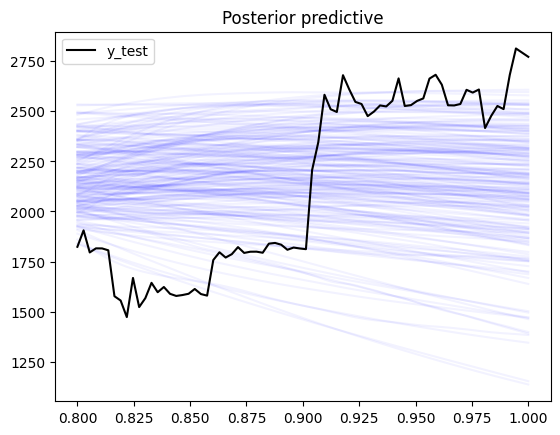

In [239]:
fig, ax = plt.subplots()
ax.plot(
    x_test,
    az.extract_dataset(pred_m_2, group="posterior_predictive", num_samples=200)["x_test"],
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_test.flatten(), y=y_test.flatten(), color="k", label='y_test', ax=ax)
ax.set_title("Posterior predictive")

In [318]:
import pytensor.tensor as tt
class PiecewiseLinear(pm.gp.mean.Mean):
    def __init__(self, breakpoint, intercept, slope1, slope2):
        super().__init__()
        self.breakpoint = breakpoint
        self.intercept = intercept
        self.slope1 = slope1
        self.slope2 = slope2
        self.trend = list()

    def __call__(self, X):
        X1 = X.flatten()
        trend = tt.switch(X1 < self.breakpoint,
                         self.intercept + self.slope1 * X1,
                         self.intercept + self.slope1 * self.breakpoint + self.slope2 * (X1 - self.breakpoint))
        #pm.Deterministic("trend",trend)
        return trend


In [410]:
with pm.Model() as model_4:

    l_matern12 = pm.HalfNormal('l_matern12', sigma=0.5)
    sigma_matern12 = pm.HalfNormal('sigma_matern12', sigma=0.5)

    eta_seasonal = pm.HalfCauchy('eta_seasonal', beta=0.5)
    l_seasonal = pm.Gamma('l_seasonal', alpha=2, beta=1.0)
    period_days = 7 / (max_day - min_day)
    period = pm.Normal('period', mu=period_days, sigma=0.05 * period_days)

    cov_seasonal = eta_seasonal**2 * pm.gp.cov.Periodic(1, period=period, ls=l_seasonal)
    cov_matern12 = sigma_matern12**2 * pm.gp.cov.Matern12(1, l_matern12)

    cov =  cov_matern12 + cov_seasonal

    bp = pm.Normal('breakpoint', mu=0.30, sigma=0.1)
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    slope1 = pm.Normal('slope1', mu=-1, sigma=1)
    slope2 = pm.Normal('slope2', mu=1, sigma=1)
    M = PiecewiseLinear(bp,intercept,slope1,slope2)

    gp = pm.gp.Marginal(cov_func=cov)
    sigma = pm.HalfNormal('sigma', sigma=1)
    wn = pm.gp.cov.WhiteNoise(sigma)

    y_obs = gp.marginal_likelihood('y', X=x_train.reshape(-1,1),y=y_train, noise=wn)

/usr/local/lib/python3.11/dist-packages/pymc/gp/gp.py:55: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)


In [411]:
with model_4:
  prior = pm.sample_prior_predictive()

<ipython-input-412-3877524624>:4: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(prior, group="prior_predictive", num_samples=100)["y"]


Text(0.5, 1.0, 'Prior predictive')

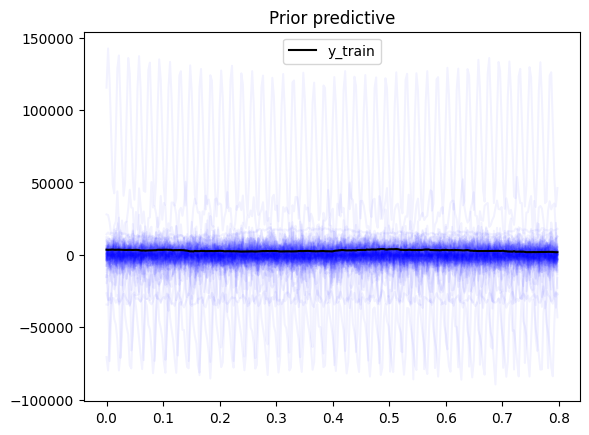

In [412]:
fig, ax = plt.subplots()
ax.plot(
    x_train,
    az.extract_dataset(prior, group="prior_predictive", num_samples=100)["y"]
    * y_train.max(),
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_train.flatten(), y=y_train.flatten(), color="k", label='y_train', ax=ax)
ax.set_title("Prior predictive")

In [415]:
with model_4:
  trace_approx_4 = pm.fit()
  trace_4 = trace_approx_4.sample()


Output()

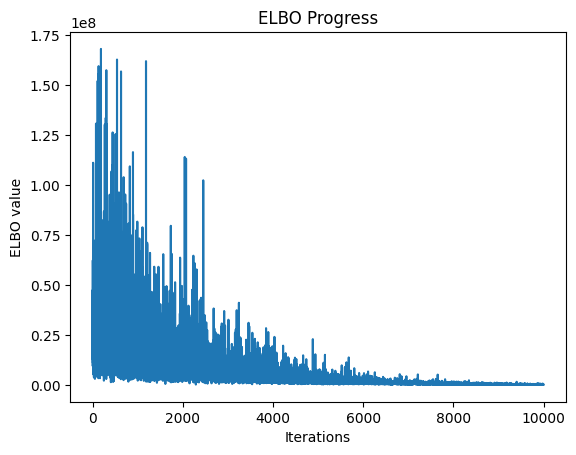

In [416]:
plt.plot(trace_approx_4.hist)
plt.title('ELBO Progress')
plt.xlabel('Iterations')
plt.ylabel('ELBO value')
plt.show()

In [422]:
with model_4:
    x_test_c = gp.conditional('x_test1', x_test.reshape(-1,1))
    pred_m_4 = pm.sample_posterior_predictive(trace_4, var_names=["x_test"])

Output()

<ipython-input-424-629536165>:4: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(pred_m_4, group="posterior_predictive", num_samples=200)["x_test"],


Text(0.5, 1.0, 'Posterior predictive')

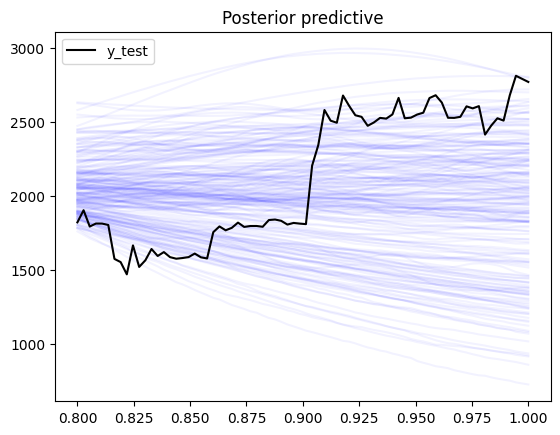

In [424]:
fig, ax = plt.subplots()
ax.plot(
    x_test,
    az.extract_dataset(pred_m_4, group="posterior_predictive", num_samples=200)["x_test"],
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_test.flatten(), y=y_test.flatten(), color="k", label='y_test', ax=ax)
ax.set_title("Posterior predictive")

In [425]:
f_pred_samples = az.extract(pred_m_4, group="posterior_predictive", var_names=["x_test"])
f_pred_samples

<xarray.DataArray 'x_test' (x_test_dim_0: 73, sample: 500)> Size: 292kB
array([[1925.53352099, 2340.44868683, 2286.35439818, ..., 2132.33339248,
        1843.1488315 , 2437.3205822 ],
       [1923.90248874, 2344.53832659, 2288.14335994, ..., 2138.43454174,
        1824.3275948 , 2447.18676335],
       [1921.99576672, 2348.35929497, 2289.42410484, ..., 2145.08537855,
        1809.51027746, 2460.15515548],
       ...,
       [1742.5138068 , 2484.16372069, 2497.85631784, ..., 2531.22848852,
        1212.00112614, 2585.94270502],
       [1741.34884574, 2482.7561862 , 2498.60879358, ..., 2526.93552088,
        1207.66161952, 2595.67893972],
       [1739.40218356, 2479.95374721, 2498.4463685 , ..., 2520.92963444,
        1197.27541827, 2597.78120977]])
Coordinates:
  * x_test_dim_0  (x_test_dim_0) int64 584B 0 1 2 3 4 5 6 ... 67 68 69 70 71 72
  * sample        (sample) object 4kB MultiIndex
  * chain         (sample) int64 4kB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
  * draw          (sample) int64 4kB 0 1 2 3 4 5 6 ... 494 495 496 497 498 499

<Axes: >

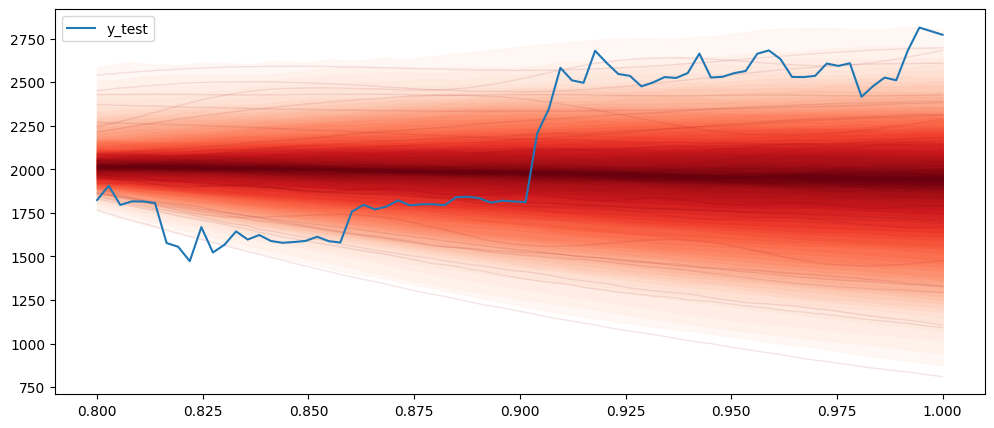

In [426]:
from pymc.gp.util import plot_gp_dist

fig = plt.figure(figsize=(12,5)); ax = fig.gca()

plot_gp_dist(ax, f_pred_samples.T, x_test);

sns.lineplot(x=x_test.flatten(), y=y_test.flatten(), label='y_test', ax=ax)

## Prophet

In [250]:
with pm.Model() as prophet:
    X_ = pm.MutableData("X", x_train)
    y_ = pm.MutableData("y", y_train)

    intercept = pm.Normal('intercept', mu=0, sigma=1)
    slope1 = pm.Normal('slope1', mu=-1, sigma=1)
    slope2 = pm.Normal('slope2', mu=1, sigma=1)
    slope3 = pm.Normal('slope3', mu=-1, sigma=1)

    bp1 = pm.Normal('bp1', mu=0.2, sigma=0.1)

    bp2_offset = pm.HalfNormal('bp2_offset', sigma=0.1)
    bp2 = pm.Deterministic('bp2', bp1 + bp2_offset)

    end_of_segment1 = intercept + slope1 * bp1
    end_of_segment2 = end_of_segment1 + slope2 * (bp2 - bp1)

    trend = pm.Deterministic(
        "trend",
        tt.switch(
            X_ < bp1,
            intercept + slope1 * X_,
            tt.switch(
                X_ < bp2,
                end_of_segment1 + slope2 * (X_ - bp1),
                end_of_segment2 + slope3 * (X_ - bp2)
            )
        )
    )

    σ = pm.HalfNormal("σ", sigma=1)
    pm.Normal("likelihood", mu=trend, sigma=σ, observed=y_)

/usr/local/lib/python3.11/dist-packages/pymc/data.py:265: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


In [251]:
with prophet:
  p_prior = pm.sample_prior_predictive()

<ipython-input-252-381628278>:4: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(p_prior, group="prior_predictive", num_samples=100)["likelihood"]
<ipython-input-252-381628278>:13: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(p_prior, group="prior", num_samples=100)["trend"] * y_train.max(),


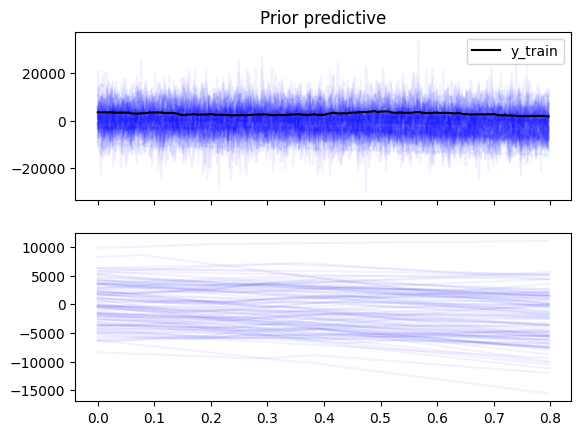

In [252]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
ax[0].plot(
    x_train,
    az.extract_dataset(p_prior, group="prior_predictive", num_samples=100)["likelihood"]
    * y_train.max(),
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_train.flatten(), y=y_train.flatten(), color="k", label='y_train', ax=ax[0])
ax[0].set_title("Prior predictive")
ax[1].plot(
    x_train,
    az.extract_dataset(p_prior, group="prior", num_samples=100)["trend"] * y_train.max(),
    color="blue",
    alpha=0.05,
)

In [253]:
with prophet:
  trace_p = pm.sample()

Output()

In [266]:
pm.summary(trace_p)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bp1,-13.510,0.054,-13.605,-13.404,0.001,0.001,1672.0,1249.0,1.0
bp2,-13.509,0.054,-13.605,-13.403,0.001,0.001,1673.0,1285.0,1.0
bp2_offset,0.001,0.001,0.000,0.004,0.000,0.000,1798.0,1095.0,1.0
intercept,7.104,0.995,5.287,8.913,0.024,0.023,1733.0,1167.0,1.0
slope1,-96.799,0.827,-98.395,-95.253,0.022,0.017,1403.0,1436.0,1.0
...,...,...,...,...,...,...,...,...,...
trend[288],2695.076,6.397,2683.198,2706.366,0.142,0.126,2002.0,1636.0,1.0
trend[289],2695.340,6.397,2683.467,2706.635,0.142,0.126,2002.0,1636.0,1.0
trend[290],2695.605,6.398,2683.735,2706.905,0.142,0.126,2002.0,1636.0,1.0
trend[291],2695.869,6.398,2683.998,2707.174,0.142,0.126,2002.0,1636.0,1.0


In [255]:
vars = {}
vars["X"] = x_test
vars["y"] = y_test

In [267]:
with prophet:
  pm.set_data(vars)
  trace_post = pm.sample_posterior_predictive(trace_p)

Output()

/usr/local/lib/python3.11/dist-packages/pymc/backends/arviz.py:68: UserWarning: No data for observation y
  warnings.warn(f"No data for observation {obs}")


<ipython-input-268-2761144921>:4: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(trace_post, group="posterior_predictive", num_samples=200)["likelihood"],


Text(0.5, 1.0, 'Posterior predictive')

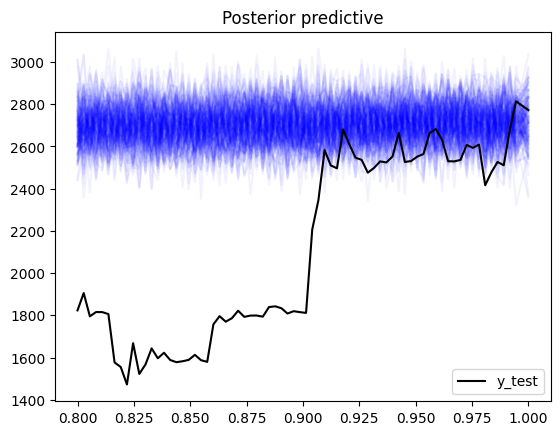

In [268]:
fig, ax = plt.subplots()
ax.plot(
    x_test,
    az.extract_dataset(trace_post, group="posterior_predictive", num_samples=200)["likelihood"],
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_test.flatten(), y=y_test.flatten(), color="k", label='y_test', ax=ax)
ax.set_title("Posterior predictive")

In [365]:
n_order = 3
def get_fourier(n_points,periods):

  x_f = np.linspace(0, periods, n_points)

  fourier_features = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * x_f / periods * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
  )

  return fourier_features

In [367]:
coords = {"fourier_features": np.arange(2 * n_order)}
coords

{'fourier_features': array([0, 1, 2, 3, 4, 5])}

In [385]:
with pm.Model(coords=coords) as prophet_p:
    X_ = pm.MutableData("X", x)
    y_ = pm.MutableData("y", y)

    n = X_.eval().shape[0]
    fs = get_fourier(n, 7)
    fourier_f = pm.MutableData("f_f", fs.values)

    β_fourier = pm.Normal("β_fourier", mu=0, sigma=1, dims="fourier_features")
    seasonality = pm.Deterministic(
        "seasonality", pm.math.dot(β_fourier, fourier_f.T)
    )

    intercept = pm.Normal('intercept', mu=0, sigma=1)
    slope1 = pm.Normal('slope1', mu=0, sigma=1)
    slope2 = pm.Normal('slope2', mu=0, sigma=1)
    slope3 = pm.Normal('slope3', mu=0, sigma=1)

    bp1 = pm.Normal('bp1', mu=0.3, sigma=0.1)

    bp2_offset = pm.HalfNormal('bp2_offset', sigma=0.1)
    bp2 = pm.Deterministic('bp2', bp1 + bp2_offset)

    end_of_segment1 = intercept + slope1 * bp1
    end_of_segment2 = end_of_segment1 + slope2 * (bp2 - bp1)

    trend = pm.Deterministic(
        "trend",
        tt.switch(
            X_ < bp1,
            intercept + slope1 * X_,
            tt.switch(
                X_ < bp2,
                end_of_segment1 + slope2 * (X_ - bp1),
                end_of_segment2 + slope3 * (X_ - bp2)
            )
        )
    )

    μ = pm.Deterministic("mu", trend * (1 + seasonality))

    σ = pm.HalfNormal("σ", sigma=1)

    likelihood = pm.Normal("likelihood", mu=μ.flatten(), sigma=σ, observed=y_)

/usr/local/lib/python3.11/dist-packages/pymc/data.py:265: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


In [386]:
with prophet_p:
  p_prior_p = pm.sample_prior_predictive()

<ipython-input-341-3950355390>:4: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(p_prior_p, group="prior_predictive", num_samples=100)["likelihood"]
<ipython-input-341-3950355390>:13: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(p_prior_p, group="prior", num_samples=100)["trend"] * y_train.max(),
<ipython-input-341-3950355390>:21: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(p_prior_p, group="prior", num_samples=100)["seasonality"]


Text(0.5, 1.0, 'Prior seasonality')

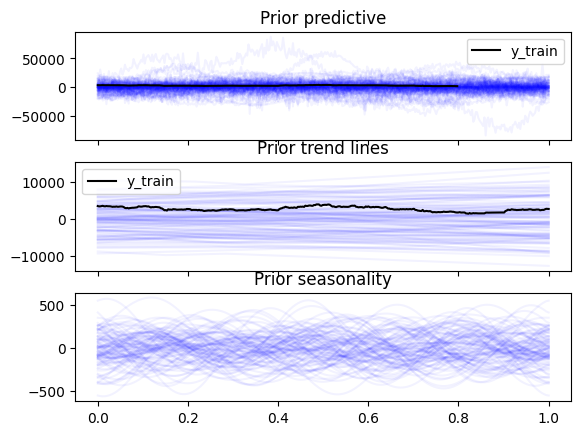

In [341]:
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True)
ax[0].plot(
    x,
    az.extract_dataset(p_prior_p, group="prior_predictive", num_samples=100)["likelihood"]
    * y.max(),
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_train.flatten(), y=y_train.flatten(), color="k", label='y_train', ax=ax[0])
ax[0].set_title("Prior predictive")
ax[1].plot(
    x,
    az.extract_dataset(p_prior_p, group="prior", num_samples=100)["trend"] * y_train.max(),
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x.flatten(), y=y.flatten(), color="k",label='y_train', ax=ax[1])
ax[1].set_title("Prior trend lines")
ax[2].plot(
    x,
    az.extract_dataset(p_prior_p, group="prior", num_samples=100)["seasonality"]
    * 100,
    color="blue",
    alpha=0.05,
)
ax[2].set_title("Prior seasonality")

In [387]:
with prophet_p:
  trace_p_p = pm.sample()

Output()

In [373]:
pm.summary(trace_p_p)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bp1,-13.471,0.050,-13.561,-13.375,0.001,0.001,2199.0,1531.0,1.00
bp2,-13.469,0.050,-13.556,-13.370,0.001,0.001,2199.0,1531.0,1.00
bp2_offset,0.001,0.001,0.000,0.004,0.000,0.000,2083.0,895.0,1.00
intercept,7.094,0.993,5.210,8.935,0.017,0.026,3578.0,1417.0,1.00
mu[0],2914.735,9.010,2898.287,2931.520,0.150,0.193,3619.0,1650.0,1.00
...,...,...,...,...,...,...,...,...,...
β_fourier[2],0.163,0.002,0.159,0.166,0.000,0.000,2819.0,1392.0,1.00
β_fourier[3],0.210,0.002,0.206,0.213,0.000,0.000,3084.0,1538.0,1.01
β_fourier[4],0.031,0.002,0.028,0.034,0.000,0.000,3504.0,1719.0,1.00
β_fourier[5],0.015,0.002,0.012,0.018,0.000,0.000,3428.0,1373.0,1.00


In [388]:
with prophet_p:
  trace_post_p = pm.sample_posterior_predictive(trace_p_p)

Output()

<ipython-input-389-852278913>:4: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(trace_post_p, group="posterior_predictive", num_samples=200)["likelihood"],


Text(0.5, 1.0, 'Posterior predictive')

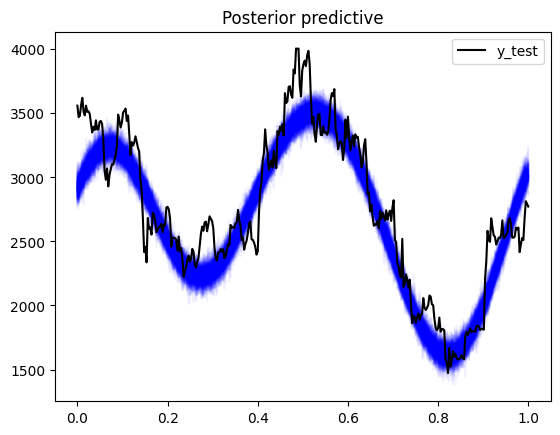

In [389]:
fig, ax = plt.subplots()
ax.plot(
    x,
    az.extract_dataset(trace_post_p, group="posterior_predictive", num_samples=200)["likelihood"],
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x.flatten(), y=y.flatten(), color="k", label='y_test', ax=ax)
ax.set_title("Posterior predictive")

## Comparacao

In [390]:
y_pred = trace_post_p.posterior_predictive["likelihood"].values.mean(axis=1)[0]
print(f"MAE: {abs(y_pred - y).sum()/len(y)}")

MAE: 179.96454327759486


In [391]:
more_days = 15
new_points = np.arange(1,(more_days+max_day)/(max_day - min_day),1/(max_day-min_day))
new_points

array([1.        , 1.00273973, 1.00547945, 1.00821918, 1.0109589 ,
       1.01369863, 1.01643836, 1.01917808, 1.02191781, 1.02465753,
       1.02739726, 1.03013699, 1.03287671, 1.03561644, 1.03835616])

In [392]:
vars = {}
vars["X"] = new_points
vars["y"] = np.zeros(len(new_points))
vars["f_f"] = get_fourier(len(new_points),7).values


In [393]:
with prophet_p:
  pm.set_data(vars)
  trace_post_p_m = pm.sample_posterior_predictive(trace_p_p)

Output()

In [394]:
likelihood_values = trace_post_p_m.posterior_predictive["likelihood"].values
mean_likelihood = np.mean(likelihood_values, axis=(0, 1))
mean_likelihood

array([3025.84340248, 3351.12743075, 3038.68395765, 2494.61187086,
       2292.05231324, 2623.04126653, 3183.20444229, 3540.77646925,
       3475.52817273, 2996.69990942, 2291.49697773, 1726.54003428,
       1690.08135158, 2266.08560839, 3028.38597132])

<ipython-input-395-3718535032>:4: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(trace_post_p, group="posterior_predictive", num_samples=200)["likelihood"],
<ipython-input-395-3718535032>:12: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(trace_post_p_m, group="posterior_predictive", num_samples=200)["likelihood"],


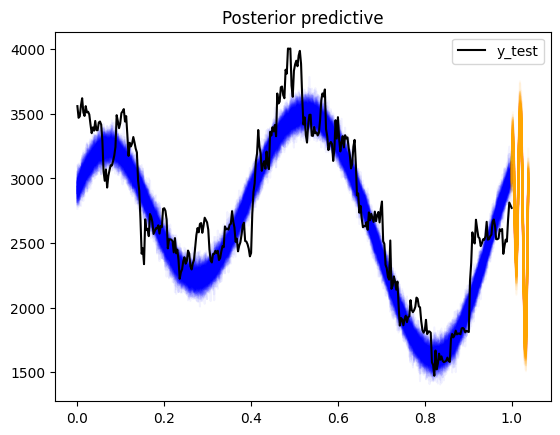

In [395]:
fig, ax = plt.subplots()
ax.plot(
    x,
    az.extract_dataset(trace_post_p, group="posterior_predictive", num_samples=200)["likelihood"],
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x.flatten(), y=y.flatten(), color="k", label='y_test', ax=ax)
ax.set_title("Posterior predictive")
ax.plot(
    new_points,
    az.extract_dataset(trace_post_p_m, group="posterior_predictive", num_samples=200)["likelihood"],
    color="orange",
    alpha=0.05,
)